Consider the 2DOF robotic structure from the figure below, for which $L1=L2=1 \;m$, $m1=m2=1\;kg$. The q1 and q2 initial conditions are $\pi$/4 and 1.
  
* Find the forward kinematics model using the D-H convention and create the robot using the robotics toolbox library DHRobot.
* Compute the C, D, and G matrices.    
* Implement in Python the robot model using the state space representation, with [odeintw](https://github.com/WarrenWeckesser/odeintw) (wrapper of odeint for working with matrices) for solving the MIMO diferential equations. Give two sine waves as the input joint torques.  
* Plot the positions and velocities compared with the inputs. Interpret the results.

<img src="../artwork/DynMod/2DOFstud.png" width=50% />

C:\Users\evely\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


ValueError: x and y must have same first dimension, but have shapes (100,) and (2,)

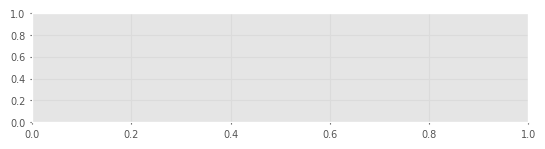

In [7]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
import math as m
from roboticstoolbox import *
from spatialmath import *
from spatialmath.base import * 
from lab_functions import lim_prismatic
from odeintw import *

##########  2C, 2D ############

pr_lim = 10

def model(x,t,u):
    u = u.reshape(2,1) # reshaping for mathematical operations
    
    q  = x[:,0]  #first column of states x, the positions
    dq = x[:,1]  #second column of states x, the velocities
    
    lim_prismatic(q,dq,pr_lim) # This is called so that the prismatic joint gets a physical limit
    
    # Define the robot's physical parameters
    m1 = 1  # Mass of link 1
    m2 = 1  # Mass of link 2
    l1 = 1  # Length of link 1
    l2 = 1  # Length of link 2
    r1 = l1 / 2  # Distance from joint axis to center of mass of link 1
    r2 = l2 / 2  # Distance from joint axis to center of mass of link 2
    I1 = m1 * l1**2 / 12  # Moment of inertia of link 1
    I2 = m2 * l2**2 / 12  # Moment of inertia of link 2
    g = 9.81  # Acceleration due to gravity
    
    # Calculate the inertia matrix D(q)
    D = np.array([[I1 + m2*l1**2 + 2*m2*l1*r2*np.cos(q[1]), I2 + m2*l1*r2*np.cos(q[1])],
                  [I2 + m2*l1*r2*np.cos(q[1]), I2]])

    # Calculate the Coriolis matrix C(q, dq)
    C = np.array([[-m2*l1*r2*np.sin(q[1])*dq[1], -m2*l1*r2*np.sin(q[1])*(dq[0]+dq[1])],
                  [m2*l1*r2*np.sin(q[1])*dq[0], 0]])
 
    # Calculate the gravity vector
    G = np.array([[m1*g*r1*np.sin(q[0]) + m2*g*(l1*np.sin(q[0]) + r2*np.sin(q[0]+q[1]))],
                  [m2*g*r2*np.sin(q[0]+q[1])]])
    
    # Compute the system velocity
    xdot1 = dq.reshape(2, 1)
    
    # Compute the system acceleration
    xdot2 = np.linalg.inv(D) @ (u - C @ dq.reshape(2, 1) - G)
    
    xdot = np.concatenate((xdot1, xdot2), axis=1)

    return xdot

# Robot model using SS representation
# Initial conditions
x0 = np.array([[0, 0], [0, 0]])

n = 100 # Number of time points
t = np.linspace(0, 10, n) # Time points

# Control inputs as sine waves
u1 = np.sin(t)
u2 = np.sin(2*t)

u = np.array([u1, u2])

# Extracting positions and velocities
q  = np.empty((n,2))
dq = np.empty((n,2))

# Recording initial conditions
q[0,:]  = x0[0,0]
dq[0,:] = x0[0,1]

for i in range(1, n):
    tspan = [t[i - 1], t[i]]
    x = odeintw(model, x0, tspan, args=(u[:,i],))

    q[i, :] = x[1][0,:]
    dq[i, :] = x[1][1,:]

    # next initial condition
    x0 = x[1]

# Plot results
plt.figure()

plt.subplot(3, 1, 1)
plt.plot(t, u[:, 0], 'g:', label='u1(t)')
plt.plot(t, u[:, 1], 'g--', label='u2(t)')
plt.ylabel('Control Input')
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(t, q[:, 0], 'b-', label='q1(t)')
plt.plot(t, q[:, 1], 'b--', label='q2(t)')
plt.ylabel('Positions')
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(t, dq[:, 0], 'r-', label='dq1(t)')
plt.plot(t, dq[:, 1], 'r--', label='dq2(t)')
plt.ylabel('Velocities')
plt.xlabel('Time')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [8]:
############### animation 
q = q.reshape(n,1)
l = 1
robot = DHRobot([ RevoluteMDH(alpha=m.pi/2, offset=m.pi/2), RevoluteMDH(d=l, alpha=m.pi/2), ], base=SE3(0.6, 0, 0), name = '2DOF robot')
zers  = np.zeros_like(q)
coord = np.concatenate((q,zers),axis=1)
robot.plot(coord, movie='1dof.gif', dt=tf/n, shadow=False)

ValueError: cannot reshape array of size 200 into shape (100,1)